# Analysis of OpenCLIP Models with and without Registers

This notebook will:
1. Detect all fine-tuned models in `outputs/` (and include the original CLIP ViT-B/16).
2. For each model, compute and plot the patch‑norm log-percentage histogram.
3. Using the no‑register model, select the top‑k images by max patch norm.
4. For those k images, visualize attention maps (original, overlay, raw) for each model.

In [29]:
import os, warnings
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import open_clip
from PIL import Image
import timm

# 1) TensorFlow oneDNN & deprecation logs
os.environ['TF_ENABLE_ONEDNN_OPTS']   = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']    = '2'   # 0=all, 1=info, 2=warning, 3=error

# 2) Python warnings filter
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 1. Setup: Model registry and dataset loader

In [30]:
val_dir = "ILSVRC2012/ILSVRC2012_split_0.8/val"

model_dir = "outputs"
models = {}

# Original OpenCLIP model (no finetune)
models["openclip_base_original"] = {"finetuned": False, "num_reg": 0, "path": None}

for fname in os.listdir(model_dir):
    if fname.endswith(".pth"):
        name = fname.replace(".pth","")
        import re
        m = re.search(r"_(\d+)_", name)
        num_reg = int(m.group(1)) if m else 0
        models[name] = {"finetuned": True, "num_reg": num_reg, "path": os.path.join(model_dir, fname)}

print("Models found:")
for k,v in models.items():
    print(f" - {k}: num_registers={v['num_reg']}, finetuned={v['finetuned']}")

# Prepare dataset (PIL images)
_, preprocess, _ = open_clip.create_model_and_transforms("ViT-B-16", pretrained="laion2b_s34b_b88k")

Models found:
 - openclip_base_original: num_registers=0, finetuned=False
 - openclip_0_registers: num_registers=0, finetuned=True
 - openclip_1_registers: num_registers=1, finetuned=True
 - openclip_4_registers: num_registers=4, finetuned=True


In [ ]:
def load_dinov2(checkpoint_path: str):
    # instantiate the ViT-B/14 feature extractor (no head)
    model = timm.create_model(
        "vit_base_patch14_224", pretrained=False, num_classes=0
    )
    state = torch.load(checkpoint_path, map_location="cpu")
    # if your .pth has a top-level 'model' key, do state = state['model']
    model.load_state_dict(state, strict=False)
    model.eval().cuda()
    return model

## 2. Helper functions

In [19]:
from openclip_with_registers import OpenCLIPWithRegisters

num_classes = len(ImageFolder(val_dir).classes)

def load_model_entry(entry, device='cuda'):
    backbone, _, _ = open_clip.create_model_and_transforms("ViT-B-16", pretrained="laion2b_s34b_b88k")
    model = OpenCLIPWithRegisters(
        vision_model = backbone.visual,
        num_registers= entry['num_reg'],
        num_classes  = num_classes
    ).to(device)
    model.eval()

    if entry['finetuned']:
        state = torch.load(entry['path'], map_location='cpu')
        model.load_state_dict(state, strict=False)

    return model

def compute_patch_norms(model, loader):
    all_norms = []
    with torch.no_grad():
        for pixels, _ in tqdm(loader, desc="Scanning ImageNet-val", unit="batch"):
            pixels = pixels.cuda(non_blocking=True)
            feats = model.forward_features(pixels)  # (B, 197, D)
            norms = feats[:, 1:, :].norm(dim=-1)  # (B,196)
            all_norms.append(norms.cpu().reshape(-1))
    return torch.cat(all_norms).view(-1).numpy()

## 3. Plot log-percentage histograms for all models

In [20]:
def get_val_loader(batch_size=64):
    ds = ImageFolder(val_dir, transform=preprocess)
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

val_loader = get_val_loader()

Plotting for model: openclip_base_original


Scanning ImageNet-val: 100%|██████████| 157/157 [01:19<00:00,  1.97batch/s]


Mean = 28.70
Std  = 3.00
Max  = 44.46
98th percentile = 44.14


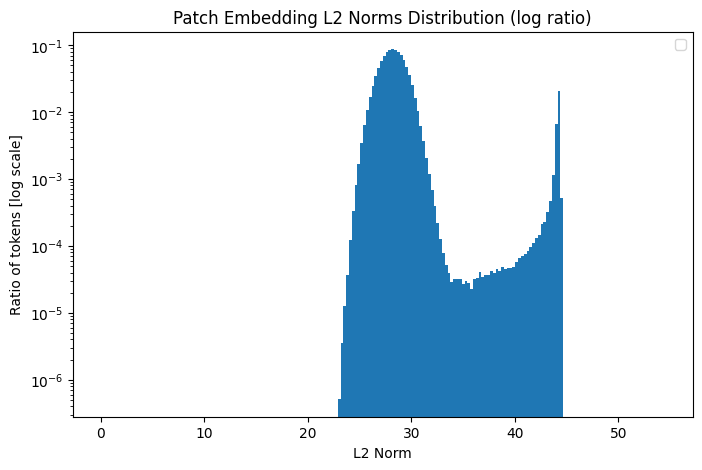

Plotting for model: openclip_0_registers


Scanning ImageNet-val: 100%|██████████| 157/157 [01:15<00:00,  2.09batch/s]


Mean = 36.59
Std  = 3.90
Max  = 49.92
98th percentile = 48.36


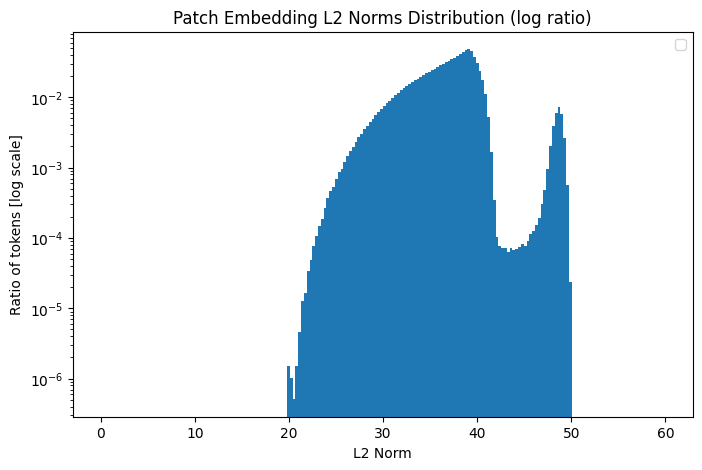

Plotting for model: openclip_1_registers


Scanning ImageNet-val: 100%|██████████| 157/157 [01:14<00:00,  2.11batch/s]


Mean = 37.37
Std  = 4.17
Max  = 51.70
98th percentile = 50.32


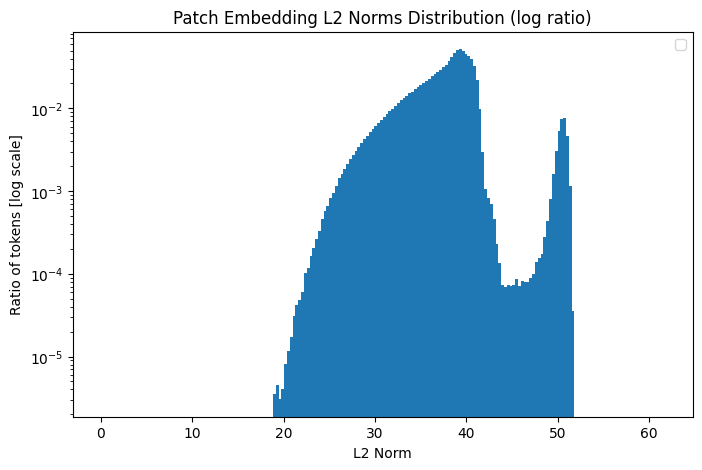

Plotting for model: openclip_4_registers


Scanning ImageNet-val: 100%|██████████| 157/157 [01:14<00:00,  2.11batch/s]


Mean = 36.40
Std  = 4.08
Max  = 49.79
98th percentile = 48.95


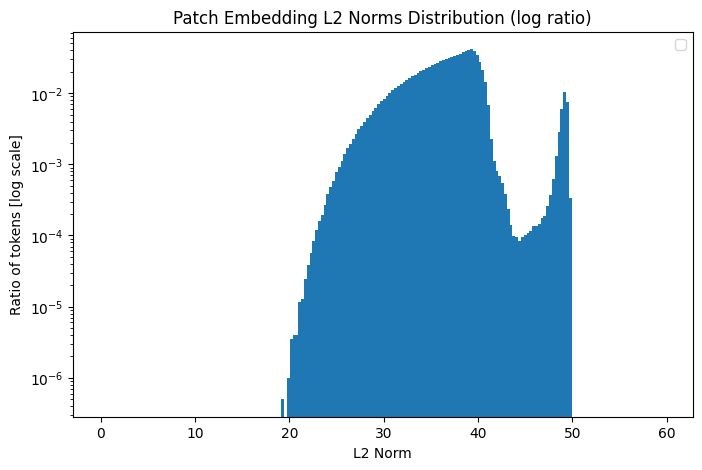

In [31]:
# Loop through each model and plot its own histogram
for name, entry in models.items():
    print(f"Plotting for model: {name}")
    model = load_model_entry(entry)
    all_norms = compute_patch_norms(model, val_loader)

    mean = all_norms.mean()
    std = all_norms.std()
    max_val = all_norms.max()
    p98 = np.percentile(all_norms, 98)

    print(f"Mean = {mean:.2f}")
    print(f"Std  = {std:.2f}")
    print(f"Max  = {max_val:.2f}")
    print(f"98th percentile = {p98:.2f}")

    plt.figure(figsize=(8, 5))
    plt.hist(
        all_norms,
        bins=200,
        range=(0, max_val + 10),
        weights=np.ones_like(all_norms) / all_norms.size
    )
    plt.yscale('log')
    plt.ylabel('Ratio of tokens [log scale]')
    plt.xlabel('L2 Norm')
    plt.title('Patch Embedding L2 Norms Distribution (log ratio)')
    plt.legend()
    plt.show()

## 4. Select top‑k images by max norm from baseline

In [1]:
num_img = 4
single_loader = get_val_loader(batch_size=1)
model_baseline = load_model_entry(models["openclip_base_original"])
max_norms = []
for idx,(img,label) in enumerate(tqdm(single_loader, desc="Scan images")):
    norm = model_baseline.forward_features(img.cuda()).norm(dim=-1)[0,1:].max().item()
    max_norms.append((idx,norm))
sorted_max = sorted(max_norms, key=lambda x:x[1], reverse=True)
top_max_norm = [i for i in sorted_max[:num_img]]
print("Top k indices of max norm:", top_max_norm)

NameError: name 'models' is not defined

## 5. Visualize attention maps for top‑k images

In [ ]:
def plot_attention_maps(model, num_reg, finetuned):
    model = model.eval().to(device)
    fig, axes = plt.subplots(len(top_max_norm), 3, figsize=(15, 5 * len(top_max_norm)))

    for i, (idx, norm_val) in enumerate(top_max_norm):
        # Load PIL image
        rel_path, _ = dataset.samples[idx]
        img = Image.open(os.path.join(val_dir, rel_path)).convert('RGB')

        # Preprocess
        inputs = processor(images=img, return_tensors="pt")["pixel_values"].to(device)

        # Forward with attentions
        with torch.no_grad():
            outputs = model(inputs, output_attentions=True)
        attns = outputs.attentions[-1][0]  # (heads, seq_len, seq_len)

        # Compute [CLS]->patch attention averaged over heads
        cls_attn = attns[:, 0, 1:].mean(0).cpu().numpy().reshape(14, 14)

        # Normalize for overlay
        hm = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min() + 1e-6)
        heatmap = Image.fromarray(hm.astype(np.float32), mode="F") \
                       .resize(img.size, Image.BICUBIC)
        heat_arr = np.array(heatmap)

        # Column 0: original
        ax0 = axes[i, 0] if len(top_max_norm)>1 else axes[0]
        ax0.imshow(img); ax0.axis('off')
        ax0.set_title(f"Img idx={idx}, max-norm={norm_val:.1f}")

        # Column 1: overlay
        ax1 = axes[i, 1] if len(top_max_norm)>1 else axes[1]
        ax1.imshow(img)
        ax1.imshow(heat_arr, cmap='jet', alpha=0.4)
        ax1.axis('off')
        ax1.set_title(f"Attention Overlay {'Original' if not finetuned else f'{num_reg} Regs'}")

        # Column 2: raw heatmap
        ax2 = axes[i, 2] if len(top_max_norm)>1 else axes[2]
        im = ax2.imshow(cls_attn, cmap='viridis', interpolation='nearest')
        ax2.axis('off')
        ax2.set_title(f"Raw Attention Map {'Original' if not finetuned else f'{num_reg} Regs'}")
        fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [ ]:
for name, entry in models.items():
    model = load_model_entry(entry)
    plot_attention_maps(model, entry['num_reg'], not entry['type'] == 'huggingface')